# Data Set

Importing libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import functions
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
np.random.seed(123)

Importing dataset

In [3]:
df = pd.read_csv('data/diabetic_data.csv')
print("The data set contains {} rows and {} columns.".format(df.shape[0],df.shape[1]))
display(df.head())

The data set contains 101766 rows and 50 columns.


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Data preparation

In [4]:
df1 = df.copy().drop_duplicates()
print("After elimination of duplicated rows. The data set contains {} rows and {} columns.".format(df1.shape[0],df1.shape[1]))
df1 = df1[df1['num_medications'] > 0]
print("After elimination of patients with no medications. The data set contains {} rows and {} columns.".format(df1.shape[0],df.shape[1]))

After elimination of duplicated rows. The data set contains 101766 rows and 50 columns.
After elimination of patients with no medications. The data set contains 101766 rows and 50 columns.


# Data Transformation

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

From categorical variables to binary variables

In [6]:
# Gender 0 for female, 1 for male
df1.drop(df1.index[df1['gender']=='Unknown/Invalid'] , inplace=True)
df1['gender'] = df1['gender'].replace({'Female': 0, 'Male': 1}).astype(int)
# max_glu_serum
df1['max_glu_serum'].fillna(0, inplace=True)
df1['max_glu_serum'] = df1['max_glu_serum'].replace({'Norm':0, '>200':1, '>300':1}).astype(int)
# A1Cresult
df1['A1Cresult'].fillna(0,inplace=True)
df1['A1Cresult'] = df1['A1Cresult'].replace({'Norm':1, '>8':1, '>7':1}).astype(int)
# race
df1['race'] = df1['race'].apply(lambda x: 'Other' if x == '?' else x)
df1['race'] = df1['race'].replace({'Caucasian':1, 'AfricanAmerican':0, 'Hispanic':0, 'Other':0, 'Asian':0}).astype(int)
# change
df1['change'] = df1['change'].replace({'No':0, 'Ch':1}).astype(int)
# diabetesMed
df1['diabetesMed'] = df1['diabetesMed'].replace({'No':0, 'Yes':1}).astype(int)

Decoding diag_1 variable according to ICD-9 index

In [7]:
import re
categories = ["circulatory", "circulatory","diabetes",  "digestive", "genitourinary","genitourinary", "musculoskeletal", "neoplasms", "neoplasms", "injury", "respiratory", "respiratory"]
regex_patterns = [
    r"\b(39[0-9])\b",  # circulatory
    r"\b(4[0-5][0-9])\b",  # circulatory
    r"\b(250*)\b", # diabetes
    r"\b5[2-7][0-9]\b",  # digestive    
    r"\b5[8-9][0-9]\b",  # genitourinary
    r"\b6[0-2][0-9]\b",  # genitourinary
    r"\b7[1-3][0-9]\b", # musculoskeletal
    r"\b1[4-9][0-9]\b", # neoplasms
    r"\b2[0-3][0-9]\b", # neoplasms
    r"\b[8-9][0-9][0-9]\b", # injury
    r"\b4[6-9][0-9]\b", # respiratory
    r"\b5[0-1][0-9]\b" # respiratory
]
code_mapping = {}
for category, regex_pattern in zip(categories, regex_patterns):
    for code in df1["diag_1"]:
        if re.match(regex_pattern, str(code)):
            code_mapping[code] = category
                   

In [8]:
df1['ICD-9'] = df1["diag_1"].map(code_mapping).fillna("Other")

Replacing age for mean of the ranges

In [9]:
df1['age']= df1['age'].apply(functions.extract_age)
df1['age'].head()

0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64

# Variable selection

Variables removed by the researchers

In [10]:
df2 = df1.copy().drop(['encounter_id','patient_nbr','weight', 'chlorpropamide', 'tolazamide','tolbutamide','examide', 'citoglipton', 'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone', 'acetohexamide', 'troglitazone', 'miglitol', 'acarbose', 'payer_code', 'medical_specialty','diag_1','diag_2','diag_3'], axis =1)

In [11]:
df2['circulatory'] = [1 if x == 'circulatory' else 0 for x in df2['ICD-9']]
df2['diabetes'] = [1 if x == 'diabetes' else 0 for x in df2['ICD-9']]
df2['digestive'] = [1 if x == 'digestive' else 0 for x in df2['ICD-9']]
df2['genitourinary'] = [1 if x == 'genitourinary' else 0 for x in df2['ICD-9']]
df2['injury'] = [1 if x == 'injury' else 0 for x in df2['ICD-9']]
df2['musculoskeletal'] = [1 if x == 'musculoskeletal' else 0 for x in df2['ICD-9']]
df2['neoplasms'] = [1 if x == 'neoplasms' else 0 for x in df2['ICD-9']]
df2['respiratory'] = [1 if x == 'respiratory' else 0 for x in df2['ICD-9']]
df2['Other'] = [1 if x == 'Other' else 0 for x in df2['ICD-9']]
df2.drop(['ICD-9'], axis=1, inplace=True)
df2.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,readmitted,circulatory,diabetes,digestive,genitourinary,injury,musculoskeletal,neoplasms,respiratory,Other
0,1,0,5,6,25,1,1,41,0,1,...,NO,0,1,0,0,0,0,0,0,0
1,1,0,15,1,1,7,3,59,0,18,...,>30,0,0,0,0,0,0,0,0,1
2,0,0,25,1,1,7,2,11,5,13,...,NO,0,0,0,0,0,0,0,0,1
3,1,1,35,1,1,7,2,44,1,16,...,NO,0,0,0,0,0,0,0,0,1
4,1,1,45,1,1,7,1,51,0,8,...,NO,0,0,0,0,0,0,1,0,0


We keep patients who had taken at least two medications

In [12]:
df2 = df2[df2['num_medications']>=2]

# Exploratory Data Analysis

## Target variable: readmitted

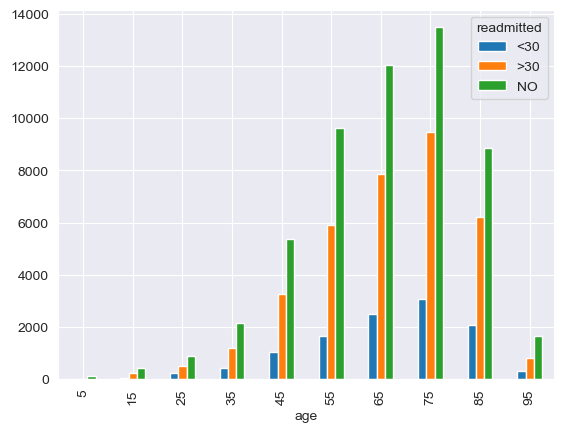

readmitted
NO     54682
>30    35473
<30    11346
Name: count, dtype: int64

In [13]:
df2.groupby(['age', 'readmitted']).size().unstack().plot(kind='bar')
plt.show()
display(df2['readmitted'].value_counts())

Let's undersample the dataset to get a balanced dataset regarding the response variable

In [14]:
df2['keep'] = df['readmitted'].apply(lambda x: functions.my_sampling(x, highest=54682, middle=35473, lowest=11346))

In [15]:
df2 = df2[df2['keep']==True].drop('keep', axis=1)
df2['readmitted'].value_counts()

readmitted
<30    11346
NO     11328
>30    11309
Name: count, dtype: int64

# Pipeline

We map the categorical and numerical variables from the training dataset

In [16]:
df_prepared = df2.drop('readmitted', axis =1 ).copy()
target = df2['readmitted']

In [17]:
cat_columns = df_prepared.select_dtypes(include=['object']).columns
num_columns = df_prepared.select_dtypes(include=['number']).columns
print("Total number of columns: {}".format(len(df_prepared.columns)))
print("Total number of categorical columns: {}".format(len(cat_columns)))
print(cat_columns)
print("Total number of numerical columns: {}".format(len(num_columns)))
print(num_columns)

Total number of columns: 37
Total number of categorical columns: 10
Index(['metformin', 'repaglinide', 'nateglinide', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'glyburide-metformin'],
      dtype='object')
Total number of numerical columns: 27
Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'circulatory', 'diabetes', 'digestive', 'genitourinary',
       'injury', 'musculoskeletal', 'neoplasms', 'respiratory', 'Other'],
      dtype='object')


## Categorical variables

Given I propose to use Random Forest and Decision Tree models from the library sckit-learn. We replace the values of the categorical columns to numbers.

In [18]:
medication_dict = { 'No':0, 'Down':1,'Steady':2, 'Up':3}
for x in cat_columns:
    df_prepared[x] = df_prepared[x].map(medication_dict)

# Training and test data

In [19]:
from sklearn.model_selection import train_test_split
X = df_prepared
y= target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
#X_train.drop('readmitted', axis=1, inplace=True)
#X_test.drop('readmitted', axis=1, inplace=True)
print("Training data shape: {}".format(X_train.shape))
print("Test data shape: {}".format(X_test.shape))

Training data shape: (27186, 37)
Test data shape: (6797, 37)


# Model: Decision Tree

## Training

In [20]:
from sklearn.tree import DecisionTreeClassifier
trees_list = []
for i in range(3,20):
    tree_clf = DecisionTreeClassifier(max_depth=int(i))
    tree_clf.fit(X_train, y_train)
    trees_list.append(tree_clf)

## Prediction

In [21]:
y_pred_list = []
for tree in trees_list:
    y_pred = tree.predict(X_test)
    y_pred_list.append(y_pred)

sensitivity_list = []
for y_pred in y_pred_list:
    comparison = y_pred == y_test
    sensitivity_list.append(comparison.sum() / len(y_test))

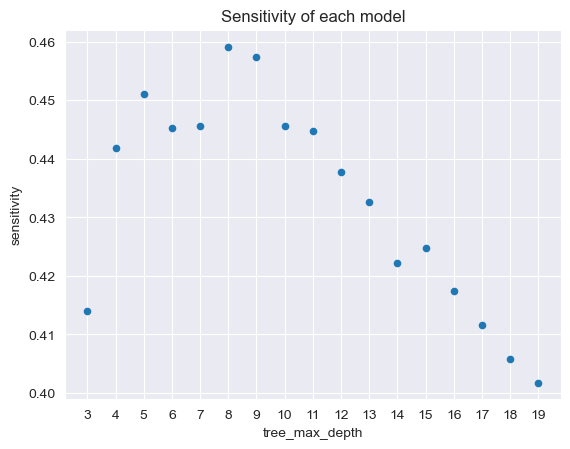

In [22]:
results = pd.DataFrame()
results['tree_max_depth'] = list(range(3,20))
results['sensitivity'] = sensitivity_list
scatter1 = results.plot(kind='scatter', x = 'tree_max_depth', y= 'sensitivity')
scatter1.set_xticks(results['tree_max_depth'])
plt.title('Sensitivity of each model')
plt.show()

From the plot, we set the max_depth of the decision tree to 8. So, we get the sensitivity of 46%.

In [23]:
decision_tree_original = trees_list[5]
decision_tree_original

DecisionTreeClassifier(max_depth=8)

## Cross validation scores

In [24]:
from sklearn.model_selection import cross_val_score
# Precision scores
precision_scores  = cross_val_score(decision_tree_original, X, y, cv=5, scoring='precision_macro')
print("Mean Cross-validation Precision Score: ", np.mean(precision_scores))
# Recall scores
recall_scores = cross_val_score(decision_tree_original, X, y, cv=5, scoring='recall_macro')
print("Mean Cross-validation Recall Score: ", np.mean(recall_scores))
# F1 scores
f1_scores = cross_val_score(decision_tree_original, X, y, cv=5, scoring='f1_macro')
print("Mean Cross-validation F1 Score: ", np.mean(f1_scores))

scores_resume = {
    'Number of features': len(X.columns),
    'Mean Cross-validation Precision Score': np.mean(precision_scores),
    'Mean Cross-validation Recall Score': np.mean(recall_scores),
    'Mean Cross-validation F1 Score': np.mean(f1_scores)
}

Mean Cross-validation Precision Score:  0.43926147053355546
Mean Cross-validation Recall Score:  0.4340435025792285
Mean Cross-validation F1 Score:  0.43132937386326703


In [25]:
validation = dict()
validation['Tree'] = scores_resume

## SHAP

In [26]:
import shap
explainer = shap.Explainer(decision_tree_original, X_train)
shap_values = explainer(X_train)

In [27]:
shap_values.shape

(27186, 37, 3)

In [28]:
shap_values_mean_dict = {}
for i in [0,1,2]:
    class_index = int(i)
    shap_values_class = shap_values.values[:, :, class_index]
    shap_values_df = pd.DataFrame(shap_values_class, columns=X_train.columns)
    mean_abs_shap_values = shap_values_df.abs().mean()
    shap_values_mean_dict[i] = mean_abs_shap_values
    
output = pd.DataFrame(shap_values_mean_dict)
output.columns = y_train.unique()
output=output.stack().reset_index()
output.columns = ['feature','class', 'mean_shap_value']
output.sort_values(by='mean_shap_value', ascending=False,inplace=True)
output.head()

,feature,class,mean_shap_value
38,number_inpatient,>30,0.088357
36,number_inpatient,NO,0.069431
12,discharge_disposition_id,NO,0.050760
13,discharge_disposition_id,<30,0.035977
14,discharge_disposition_id,>30,0.035032


In [29]:
output['cumulative_shap_value'] = output.groupby('class')['mean_shap_value'].cumsum() 
total_relative_dict = dict(output.groupby('class')['mean_shap_value'].sum()) #len(output)
output['cumulative_relative_shap_value'] =  output['cumulative_shap_value'] / output['class'].map(total_relative_dict)
columns_remain = []
threshold = float(0.75)

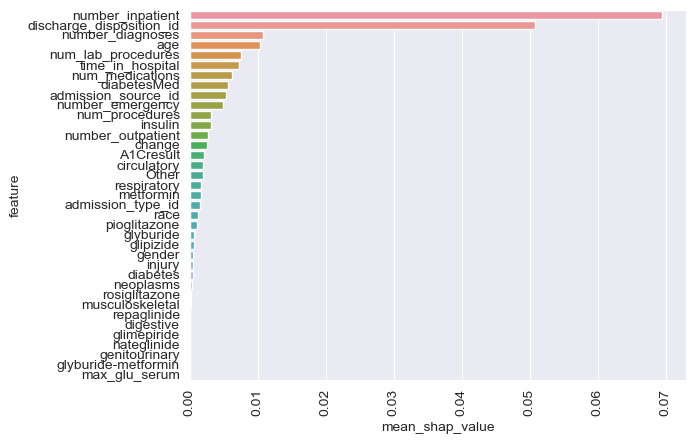

In [30]:
sns.barplot(y='feature', x= 'mean_shap_value', data =output[output['class']=='NO'])
plt.xticks(rotation=90)
plt.show()

In [31]:
display_df = output[(output['class']=='NO') & (output['cumulative_relative_shap_value']<threshold)]
columns_remain.extend(display_df['feature'])
display(display_df)

,feature,class,mean_shap_value,cumulative_shap_value,cumulative_relative_shap_value
36,number_inpatient,NO,0.069431,0.069431,0.335414
12,discharge_disposition_id,NO,0.050760,0.120191,0.580628
39,number_diagnoses,NO,0.010746,0.130937,0.632541
6,age,NO,0.010352,0.141289,0.682550
21,num_lab_procedures,NO,0.007534,0.148823,0.718946


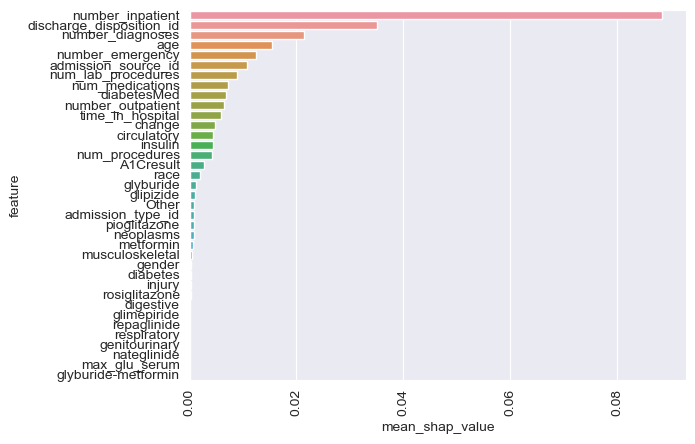

In [32]:
sns.barplot(y='feature', x= 'mean_shap_value', data =output[output['class']=='>30'])
plt.xticks(rotation=90)
plt.show()

In [33]:
display_df = output[(output['class']=='>30') & (output['cumulative_relative_shap_value']<threshold)]
columns_remain.extend(display_df['feature'])
display(display_df)

,feature,class,mean_shap_value,cumulative_shap_value,cumulative_relative_shap_value
38,number_inpatient,>30,0.088357,0.088357,0.355605
14,discharge_disposition_id,>30,0.035032,0.123389,0.496594
41,number_diagnoses,>30,0.021342,0.144730,0.582487
8,age,>30,0.015409,0.160140,0.644503
35,number_emergency,>30,0.012356,0.172495,0.694231
17,admission_source_id,>30,0.010779,0.183275,0.737614


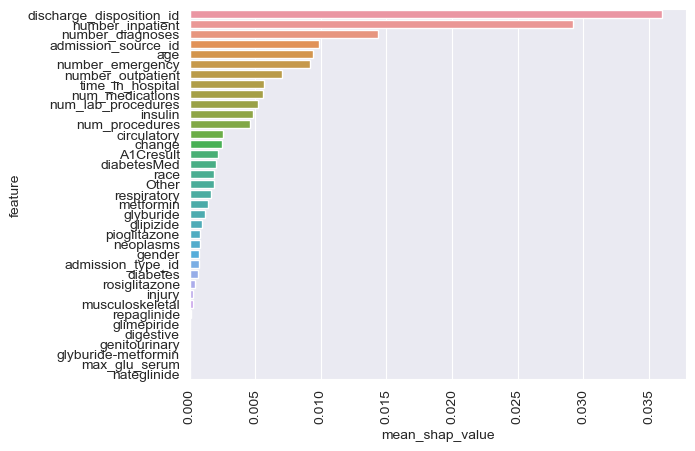

In [34]:
sns.barplot(y='feature', x= 'mean_shap_value', data =output[output['class']=='<30'])
plt.xticks(rotation=90)
plt.show()

In [35]:
display_df = output[(output['class']=='<30') & (output['cumulative_relative_shap_value']<threshold)]
columns_remain.extend(display_df['feature'])
display(display_df)

,feature,class,mean_shap_value,cumulative_shap_value,cumulative_relative_shap_value
13,discharge_disposition_id,<30,0.035977,0.035977,0.219380
37,number_inpatient,<30,0.029240,0.065217,0.397682
40,number_diagnoses,<30,0.014349,0.079566,0.485180
16,admission_source_id,<30,0.009891,0.089457,0.545496
7,age,<30,0.009371,0.098828,0.602638
34,number_emergency,<30,0.009211,0.108039,0.658804
31,number_outpatient,<30,0.007051,0.115090,0.701801
19,time_in_hospital,<30,0.005648,0.120738,0.736242


In [36]:
columns_remain = list(set(columns_remain))

In [37]:
print("New set of columns has a length of {}, the initial number of features where {}". format(len(columns_remain), len(cat_columns)+len(num_columns)))

New set of columns has a length of 9, the initial number of features where 37


## New model with reduced number of features

In [38]:
rfe_tree_clf = DecisionTreeClassifier(max_depth=8)
rfe_tree_clf.fit(X_train[list(columns_remain)], y_train)

DecisionTreeClassifier(max_depth=8)

In [39]:
from sklearn.model_selection import cross_val_score
# Precision scores
precision_scores  = cross_val_score(rfe_tree_clf, X[columns_remain], y, cv=5, scoring='precision_macro')
print("Mean Cross-validation Precision Score: ", np.mean(precision_scores))
# Recall scores
recall_scores = cross_val_score(rfe_tree_clf, X[columns_remain], y, cv=5, scoring='recall_macro')
print("Mean Cross-validation Recall Score: ", np.mean(recall_scores))
# F1 scores
f1_scores = cross_val_score(rfe_tree_clf, X[columns_remain], y, cv=5, scoring='f1_macro')
print("Mean Cross-validation F1 Score: ", np.mean(f1_scores))

scores_resume = {
    'Number of features': len(X[columns_remain].columns),
    'Mean Cross-validation Precision Score': np.mean(precision_scores),
    'Mean Cross-validation Recall Score': np.mean(recall_scores),
    'Mean Cross-validation F1 Score': np.mean(f1_scores)
}

Mean Cross-validation Precision Score:  0.4347004277117664
Mean Cross-validation Recall Score:  0.43627867714926793
Mean Cross-validation F1 Score:  0.42762475503690534


In [40]:
validation['Tree RFE'] = scores_resume

# Model: Random Forest

## Training

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

## Prediction

In [42]:
y_pred = rf.predict(X_test)
comparison = y_pred == y_test
comparison.sum() / len(y_test)

0.44387229660144184

## Cross validation score

In [43]:
from sklearn.model_selection import cross_val_score
# Precision scores
precision_scores  = cross_val_score(rf, X, y, cv=5, scoring='precision_macro')
print("Mean Cross-validation Precision Score: ", np.mean(precision_scores))
# Recall scores
recall_scores = cross_val_score(rf, X, y, cv=5, scoring='recall_macro')
print("Mean Cross-validation Recall Score: ", np.mean(recall_scores))
# F1 scores
f1_scores = cross_val_score(rf, X, y, cv=5, scoring='f1_macro')
print("Mean Cross-validation F1 Score: ", np.mean(f1_scores))

scores_resume = {
    'Number of features': len(X.columns),
    'Mean Cross-validation Precision Score': np.mean(precision_scores),
    'Mean Cross-validation Recall Score': np.mean(recall_scores),
    'Mean Cross-validation F1 Score': np.mean(f1_scores)
}

Mean Cross-validation Precision Score:  0.43955172781454277
Mean Cross-validation Recall Score:  0.4382727262311583
Mean Cross-validation F1 Score:  0.41244026624402386


In [44]:
validation['RF'] = scores_resume

## SHAP

In [45]:
import shap
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train)

100%|===================| 81356/81558 [04:16<00:00]        

In [46]:
shap_values.shape

(27186, 37, 3)

In [47]:
shap_values_mean_dict = {}
for i in [0,1,2]:
    class_index = int(i)
    shap_values_class = shap_values.values[:, :, class_index]
    shap_values_df = pd.DataFrame(shap_values_class, columns=X_train.columns)
    mean_abs_shap_values = shap_values_df.abs().mean()
    shap_values_mean_dict[i] = mean_abs_shap_values
    
output = pd.DataFrame(shap_values_mean_dict)
output.columns = y_train.unique()
output=output.stack().reset_index()
output.columns = ['feature','class', 'mean_shap_value']
output.sort_values(by='mean_shap_value', ascending=False,inplace=True)
output.head()

,feature,class,mean_shap_value
38,number_inpatient,>30,0.049283
36,number_inpatient,NO,0.037639
12,discharge_disposition_id,NO,0.020932
35,number_emergency,>30,0.014054
13,discharge_disposition_id,<30,0.013151


In [48]:
output['cumulative_shap_value'] = output.groupby('class')['mean_shap_value'].cumsum() 
total_relative_dict = dict(output.groupby('class')['mean_shap_value'].sum()) #len(output)
output['cumulative_relative_shap_value'] =  output['cumulative_shap_value'] / output['class'].map(total_relative_dict)
columns_remain = []
threshold = float(0.75)

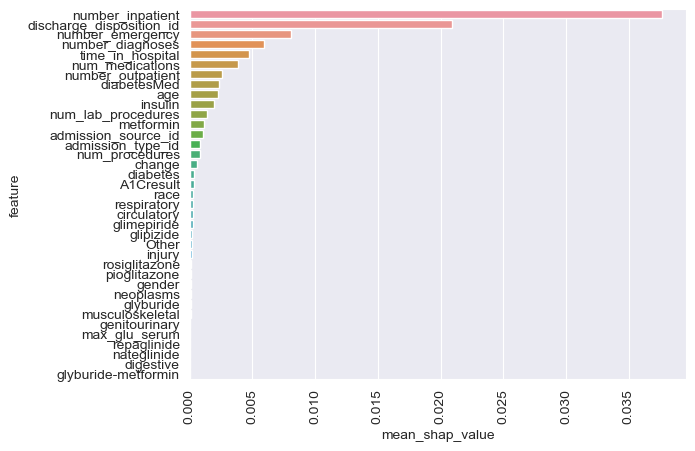

In [49]:
sns.barplot(y='feature', x= 'mean_shap_value', data =output[output['class']=='NO'])
plt.xticks(rotation=90)
plt.show()

In [50]:
display_df = output[(output['class']=='NO') & (output['cumulative_relative_shap_value']<threshold)]
columns_remain.extend(display_df['feature'])
display(display_df)

,feature,class,mean_shap_value,cumulative_shap_value,cumulative_relative_shap_value
36,number_inpatient,NO,0.037639,0.037639,0.378356
12,discharge_disposition_id,NO,0.020932,0.058572,0.588771
33,number_emergency,NO,0.008050,0.066622,0.669696
39,number_diagnoses,NO,0.005948,0.072570,0.729486


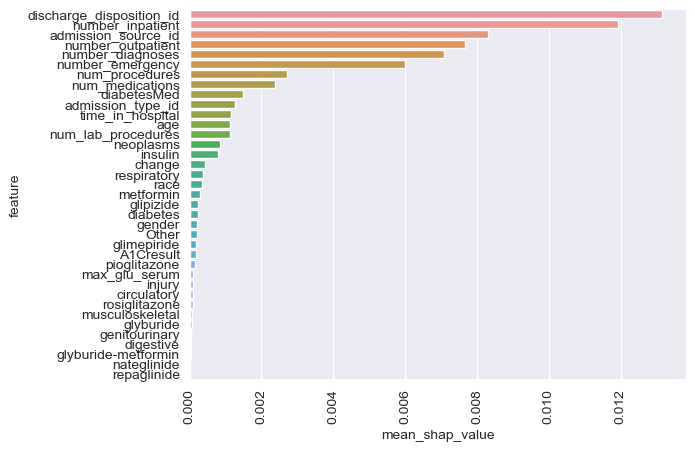

In [51]:
sns.barplot(y='feature', x= 'mean_shap_value', data =output[output['class']=='<30'])
plt.xticks(rotation=90)
plt.show()

In [52]:
display_df = output[(output['class']=='<30') & (output['cumulative_relative_shap_value']<threshold)]
columns_remain.extend(display_df['feature'])
display(display_df)

,feature,class,mean_shap_value,cumulative_shap_value,cumulative_relative_shap_value
13,discharge_disposition_id,<30,0.013151,0.013151,0.186103
37,number_inpatient,<30,0.011940,0.025090,0.355071
16,admission_source_id,<30,0.008308,0.033399,0.472649
31,number_outpatient,<30,0.007674,0.041072,0.581243
40,number_diagnoses,<30,0.007085,0.048157,0.681505


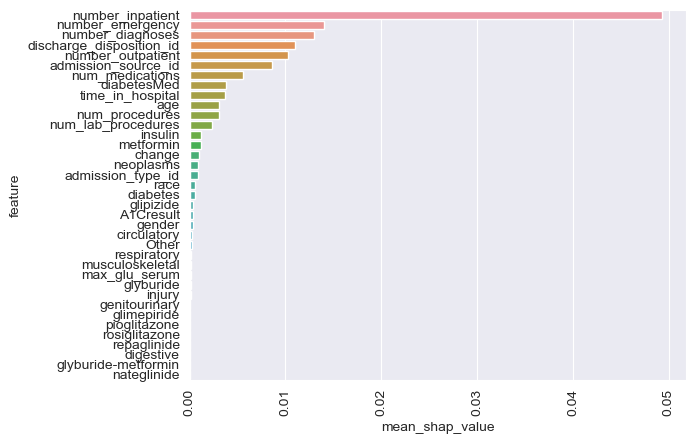

In [53]:
sns.barplot(y='feature', x= 'mean_shap_value', data =output[output['class']=='>30'])
plt.xticks(rotation=90)
plt.show()

In [54]:
display_df = output[(output['class']=='>30') & (output['cumulative_relative_shap_value']<threshold)]
columns_remain.extend(display_df['feature'])
display(display_df)

,feature,class,mean_shap_value,cumulative_shap_value,cumulative_relative_shap_value
38,number_inpatient,>30,0.049283,0.049283,0.360397
35,number_emergency,>30,0.014054,0.063336,0.463169
41,number_diagnoses,>30,0.013021,0.076358,0.558391
14,discharge_disposition_id,>30,0.010953,0.087311,0.638491
32,number_outpatient,>30,0.010252,0.097563,0.713465


In [55]:
columns_remain = list(set(columns_remain))
print("New set of columns has a length of {}, the initial number of features where {}".format(len(columns_remain),len(cat_columns) + len(num_columns)))

New set of columns has a length of 6, the initial number of features where 37


## New model with reduced number of features

In [56]:
rfe_rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rfe_rf.fit(X_train[list(columns_remain)], y_train)

RandomForestClassifier(max_depth=5)

In [57]:
from sklearn.model_selection import cross_val_score
# Precision scores
precision_scores  = cross_val_score(rfe_rf, X[columns_remain], y, cv=5, scoring='precision_macro')
print("Mean Cross-validation Precision Score: ", np.mean(precision_scores))
# Recall scores
recall_scores = cross_val_score(rfe_rf, X[columns_remain], y, cv=5, scoring='recall_macro')
print("Mean Cross-validation Recall Score: ", np.mean(recall_scores))
# F1 scores
f1_scores = cross_val_score(rfe_rf, X[columns_remain], y, cv=5, scoring='f1_macro')
print("Mean Cross-validation F1 Score: ", np.mean(f1_scores))

scores_resume = {
    'Number of features': len(X[columns_remain].columns),
    'Mean Cross-validation Precision Score': np.mean(precision_scores),
    'Mean Cross-validation Recall Score': np.mean(recall_scores),
    'Mean Cross-validation F1 Score': np.mean(f1_scores)
}

Mean Cross-validation Precision Score:  0.43853117637500016
Mean Cross-validation Recall Score:  0.4385567061222413
Mean Cross-validation F1 Score:  0.41599288968246056


In [58]:
validation['RF RFE'] = scores_resume

In [59]:
validation_df = pd.DataFrame.from_dict(validation, orient='index')
validation_df

,Number of features,Mean Cross-validation Precision Score,Mean Cross-validation Recall Score,Mean Cross-validation F1 Score
Tree,37,0.439261,0.434044,0.431329
Tree RFE,9,0.434700,0.436279,0.427625
RF,37,0.439552,0.438273,0.412440
RF RFE,6,0.438531,0.438557,0.415993


# Conclusion

From the previous dataframe, we can compare regarding the three decision models, that the all the scores (Precision Score, Recall Score, F1 Score) present similar values if the model is trained with the full set of features or the ranked 9 features from their SHAP values.
It's the same case for the pair of random forest models, where the original model uses the full set of 37 features, meanwhile, the second one offers similar scores after being trained with the 6 most important features.